In [52]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
from seaborn import plt
# import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, feature_selection
from sklearn.cross_validation import train_test_split, cross_val_score

In [3]:
from sklearn.datasets import load_iris

In [5]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df.head(4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0


In [18]:
df = iris_df.copy()
df.columns = ['slength','swidth','plength','pwidth','Target']
df.head(4)

,slength,swidth,plength,pwidth,Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0


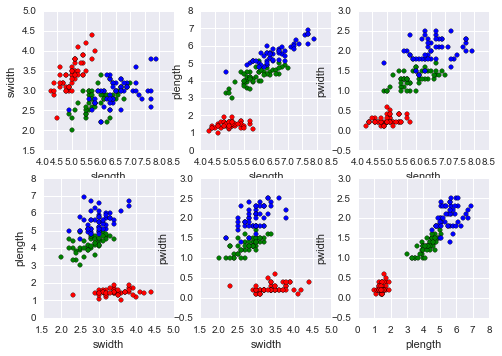

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3)

colors = ['r','g','b']
for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='slength',y='swidth', kind='scatter', c=colors[i], ax=axes[0,0])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='slength',y='plength', kind='scatter', c=colors[i], ax=axes[0,1])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='slength',y='pwidth', kind='scatter', c=colors[i], ax=axes[0,2])
    
for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='swidth',y='plength', kind='scatter', c=colors[i], ax=axes[1,0])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='swidth',y='pwidth', kind='scatter', c=colors[i], ax=axes[1,1])

for i in range(3): 
    tmp = df[df.Target == i]
    tmp.plot(x='plength',y='pwidth', kind='scatter', c=colors[i], ax=axes[1,2])


In [59]:
X_train, X_test, y_train, y_test = train_test_split(df[['slength','swidth','plength','pwidth']], df.Target, test_size=0.3, random_state=12)

30 | [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]

Optimal number of neighbors: 11


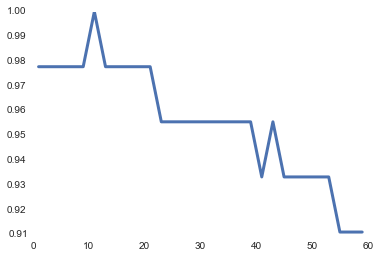

In [87]:
scores = []
n_neighbors = range(1, 60, 2)
print len(n_neighbors),"|",n_neighbors
for n in n_neighbors:
    clf = neighbors.KNeighborsClassifier(n)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
plt.plot(n_neighbors, scores, linewidth=3.0)
print
maxValues = [{'index':i,'score':x} for i,x in enumerate(scores) if x == max(scores)][0]
optimumNeighbors = n_neighbors[maxValues['index']]
print "Optimal number of neighbors: {:d}".format(optimumNeighbors)


In [93]:
clf = neighbors.KNeighborsClassifier(optimumNeighbors) # 11
clf.fit(X_train, y_train)
print clf.predict(X_test) == y_test

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [356]:
clf = neighbors.KNeighborsClassifier(11, weights='uniform') ### k=11 was best from earlier result. 
clf.fit(df.ix[:,0:4], df.Target)
scores = cross_val_score(clf, X=df.ix[:,0:4], y=df.Target, cv=5)
print scores
print scores.mean()

[ 0.93333333  1.          1.          0.96666667  1.        ]
0.98


In [411]:
def randomizeLists(*arrays):
    indexes = range(0,len(arrays[0]))
    np.random.shuffle(indexes)
    arraysToReturn = tuple()
    for a in arrays:
        randomizedA = [a[i] for i in indexes]
        arraysToReturn += tuple([randomizedA])
    return arraysToReturn
        
def custom_cross_validation_score(clf,X,y,folds=5,randomize=True):
    foldSize = int(len(X)/folds)
    foldIndexStart = 0
    if randomize: X,y = randomizeLists(X,y)
    scores = []
    for n in range(0,folds):
        foldIndexEnd = foldIndexStart+foldSize
        X_test_fold = X[foldIndexStart:foldIndexEnd]
        y_test_fold = y[foldIndexStart:foldIndexEnd]
        X_train_fold = [x for i,x in enumerate(X) if i < foldIndexStart or i >= foldIndexEnd]
        y_train_fold = [Y for i,Y in enumerate(y) if i < foldIndexStart or i >= foldIndexEnd]
        clf.fit(X_train_fold,y_train_fold)
        scores.append(clf.score(X_test_fold,y_test_fold))
        foldIndexStart+=foldSize
    return np.asarray(scores)
        
        
    
clf = neighbors.KNeighborsClassifier(11, weights='uniform')
X = df.ix[:,0:4].values
y = df.Target
scores = custom_cross_validation_score(clf,X,y, folds=5,randomize=True)
print scores
print scores.mean()

[ 0.96666667  0.96666667  1.          1.          0.93333333]
0.973333333333


In [482]:
class custom_KNearestNeigbhors_classifier:
    def __init__(self,k):
        self.k = k
        
    def fit(self,X,y):
        self.pointMatrix = []
        for i, features in enumerate(X):
            point = {}
            point['features'] = features
            point['label'] = y[i]
            self.pointMatrix.append(point)
    
    def predict(self,X,y):
        predictions = []
        for i,features in enumerate(X):
            distanceScores = []
            for point in self.pointMatrix:
                distance = self.calculateDistance(features,point['features'])
                distanceScores.append({'distance':distance,'label':point['label']})
                
            distanceScores.sort() ## order lowest distance to highest distance
            topKlabels =[ score['label'] for score in distanceScores[:self.k]]
            
            ### need to look for better function to find max count in list
            topKlabelDict = {}
            for k in topKlabels:
                if k in topKlabelDict:
                    topKlabelDict[k]+=1
                else:
                    topKlabelDict[k]=1
            
            ### and max function extends to hered..
            predictedLabel = {'label': None, 'value': 0}
            for k,v in topKlabelDict.items(): 
                if v > predictedLabel['value']:
                    predictedLabel['label'] = k
#             print topKlabelDict
#             print topKlabels
#             print predictedLabel
#             print
                    
                    
            predictions.append(predictedLabel['label'])
        return predictions
        
    def calculateDistance(self,a,b):
        ### NO IDEA WHAT DISTANCE FUNCTION IS
        return sum([abs(x-b[i]) for i,x in enumerate(list(a))])
    

clf  = custom_KNearestNeigbhors_classifier(11)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test,y_test)
print predictions
print y_test
print "Accuracy Score: {:2f}%".format(sum(sum( [ predictions == y_test ] ))/ len(predictions))

[0, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
[0 2 0 1 2 2 2 0 2 0 1 0 0 0 1 2 2 1 0 1 0 1 2 1 0 2 1 1 0 0 0 1 2 0 2 0 1
 1 0 1 1 0 0 0 0]
Accuracy Score: 0.911111%
